In [1]:
%load_ext autoreload

%autoreload 2



In [21]:
# from pyimzml.ImzMLParser import ImzMLParser
from masserstein import Spectrum

from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import pairwise_distances

from entropic_regularized_distance import calculate_distance

import datetime

import matplotlib.pyplot as plt

import gc

import math

In [2]:
# Get data

# p = ImzMLParser('data/mouse_cebellum/test_POS.imzML')
# dimensions = (max(coor[0] for coor in p.coordinates),
#               max(coor[1] for coor in p.coordinates))
# # We know that z has only one value - 1
# picture = [[None for y in range(dimensions[1])] for x in range(dimensions[0])]
# for idx, (x, y, z) in enumerate(p.coordinates):
#     mzs, intensities = p.getspectrum(idx)
#     s = Spectrum('', empty=True, label=str(x) + ", " + str(y))
#     s.confs = list(zip(mzs, intensities))
#     picture[x - 1][y - 1] = s
dimensions = (81, 21)
picture = [[None for y in range(dimensions[1])] for x in range(dimensions[0])]
with open("data/mouse_cebellum/peak_picked_brain.tsv", "r") as infile:
    mzs = list(map(float, next(infile).strip().split("\t")[2:]))
    for line in infile:
        line = line.strip().split("\t")
        x, y = map(int, line[:2])
        intensities = list(map(float, line[2:]))
        s = Spectrum('', empty=True, label=str(x) + ", " + str(y))
        s.set_confs(list(zip(mzs, intensities)))
        picture[x - 1][y - 1] = s

In [3]:
dimensions

(81, 21)

In [16]:
def flatten(l):
    return [item for sublist in l for item in sublist]




flat_picture = flatten(picture)

In [17]:


from optimal_transport_py import quick_distance

def own_affinity():
    count = 0
    distances = np.zeros((len(flat_picture), len(flat_picture)))
    for i, row in enumerate(distances):
        for j in range(i + 1):
            gc.collect()
            distances[i][j] = quick_distance(flat_picture[i],
                                                 flat_picture[j])
            count += 1
            # if count % 100 == 0:
            # print(datetime.datetime.now(), count, i, j)
    return distances
            


# distance_matrix = own_affinity()

    


In [6]:
# gc.collect()
# # from entropic_regularized_distance import global_vs
# import cProfile
# cProfile.run('calculate_distance(flat_picture[80], flat_picture[20])')
# # calculate_distance(flat_picture[4], flat_picture[3])


In [8]:
# from multiprocessing import Pool

# def par_distance(arg):
#     i, j = arg
#     return calculate_distance(flat_picture[i], flat_picture[j]), i, j
    

# def ind_generator():
#     count = 0
#     for i in range(len(flat_picture)):
#         for j in range(len(flat_picture)):
#             count += 1
#             if count % 10 == 0:
#                 print("Now yielding ", count)
#                 return
#             yield (i, j)
#     return

# def own_affinity_paralel():
#     pool = Pool(2)
#     distance_matrix = [[None for y in range(len(flat_picture))] for x in range(len(flat_picture))]
#     for dist, i, j in pool.imap_unordered(par_distance, ind_generator(), chunksize=2):
#         distance_matrix[i][j] = dist
#     return distance_matrix


distance_matrix = own_affinity_paralel()

Now yielding  10


In [4]:
# import json
# with open("data/mouse_cebellum/distances.json", "w") as outfile:
#     json.dump(distance_matrix, outfile)
    
    
import json
with open("data/mouse_cebellum/distances.json", "r") as infile:
    distance_matrix = json.load(infile)
    
    
distance_matrix = np.array(distance_matrix)
    

In [5]:
import matplotlib.pyplot as plt

%matplotlib notebook
?fig.colorbar


Object `fig.colorbar` not found.


<IPython.core.display.Javascript object>


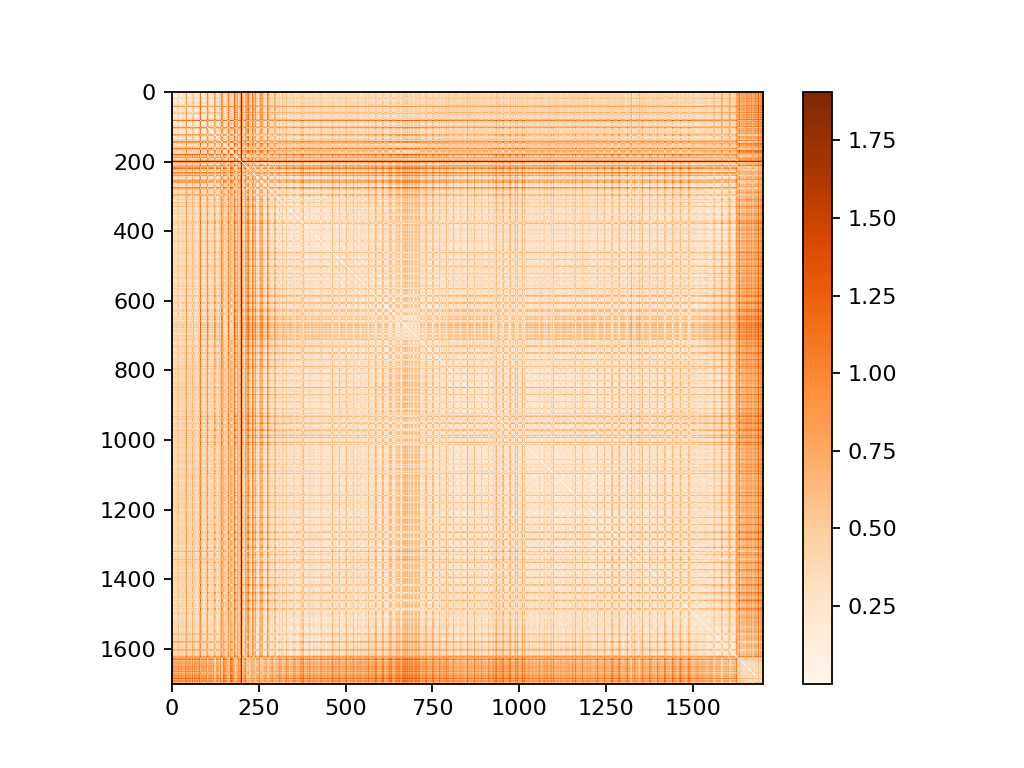

In [6]:
fig, ax = plt.subplots()
im = ax.imshow(distance_matrix, cmap=plt.get_cmap("Oranges"))

fig.colorbar(im)

# fig.tight_layout()
plt.show()

In [7]:
print(min(min(l) for l in distance_matrix))


0.000282714520052601


In [115]:
ac = AgglomerativeClustering(n_clusters=None, affinity='precomputed',
                             linkage='average', compute_full_tree=True,
                             distance_threshold=0.45)
labels = ac.fit_predict(distance_matrix)



In [112]:
labels


array([2, 2, 2, ..., 0, 0, 0])

In [113]:
label_picture = [[None for y in range(dimensions[1])] for x in range(dimensions[0])]

indexes = [(i, j) for i, sublist in enumerate(picture) for j, item in enumerate(sublist)]

for n, (i, j) in zip(labels, indexes):
    label_picture[i][j] = n


<IPython.core.display.Javascript object>


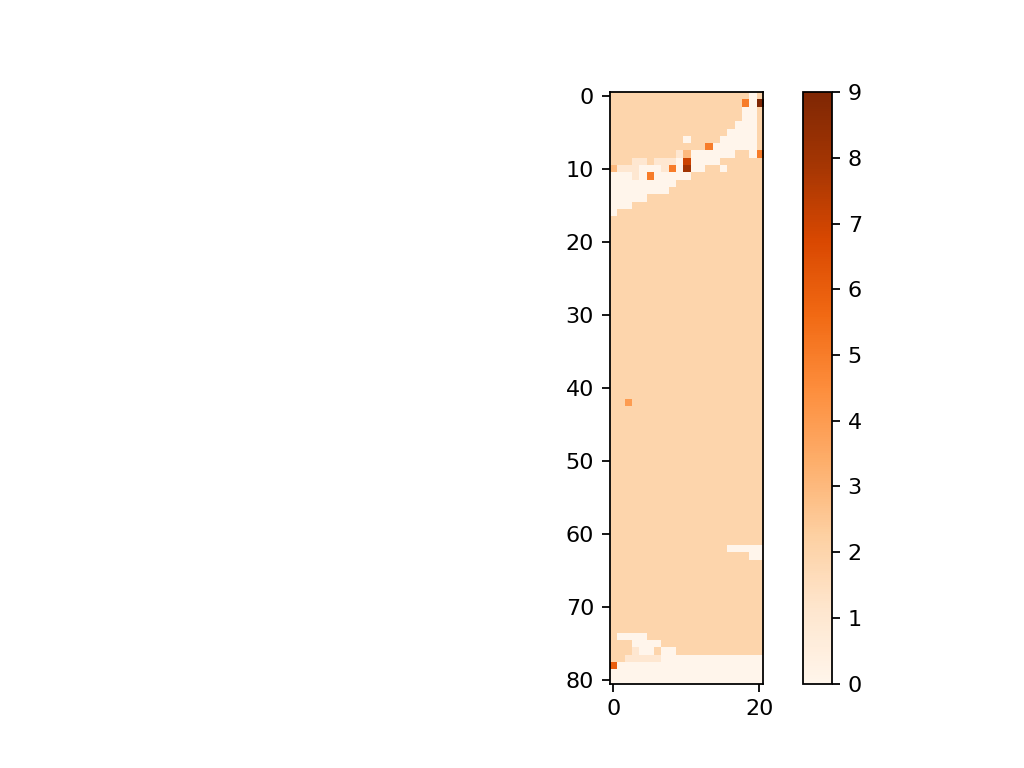

In [114]:
fig, ax = plt.subplots()
# x = 
im = ax.imshow(label_picture, cmap=plt.get_cmap("Oranges"))

fig.colorbar(im)

# fig.tight_layout()
plt.show()



In [22]:
# Compare with correlation
for sp in flat_picture:
    sp.cut_smallest_peaks(0.01)
    sp.coarse_bin(1)
    sp.norm = math.sqrt(sum(x[1] ** 2 for x in sp.confs))
    
sp.plot()

In [87]:
similarities = [[None for _ in range(len(flat_picture))] for _ in range(len(flat_picture))]



def similarity_distance(spec1, spec2):
    i1, i2 = 0, 0
    ret = 0.0

    while i2 < len(spec2.confs):
#         print("Looping")
        while i1 < len(spec1.confs) and spec1.confs[i1][0] < spec2.confs[i2][0]:
#             print("I1", spec1.confs[i1], i1, spec2.confs[i2], i2)
            i1 += 1
        if i1 == len(spec1.confs):
            break
        while i2 < len(spec2.confs) and spec2.confs[i2][0] < spec1.confs[i1][0]:
#             print("I2", spec1.confs[i1], i1, spec2.confs[i2], i2)
            i2 += 1
        if i2 == len(spec2.confs):
            break
        if spec1.confs[i1][0] == spec2.confs[i2][0]:
#             print("Add", i1, i2, spec1.confs[i1][0], spec2.confs[i2][0])
            ret += spec1.confs[i1][1] * spec2.confs[i2][1]
            i2 += 1
    return ret / (spec1.norm * spec2.norm)

In [93]:


start = datetime.datetime.now()
for i, si in enumerate(flat_picture):
    for j, sj in enumerate(flat_picture):
        similarities[i][j] = similarity_distance(si, sj)


print(datetime.datetime.now() - start)

for i in range(len(similarities)):
    for j in range(len(similarities[i])):
        similarities[i][j] = 1 - similarities[i][j]

0:34:55.454856


<IPython.core.display.Javascript object>


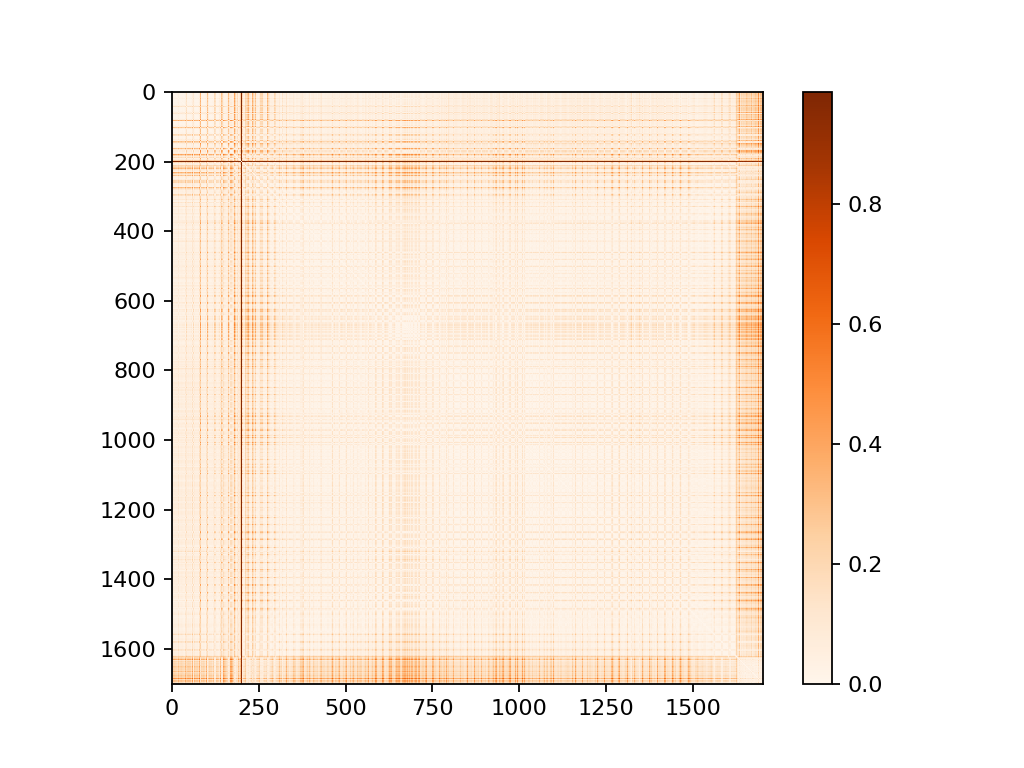

In [94]:
# TODO cluster
fig, ax = plt.subplots()
im = ax.imshow(similarities, cmap=plt.get_cmap("Oranges"))

fig.colorbar(im)

# fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


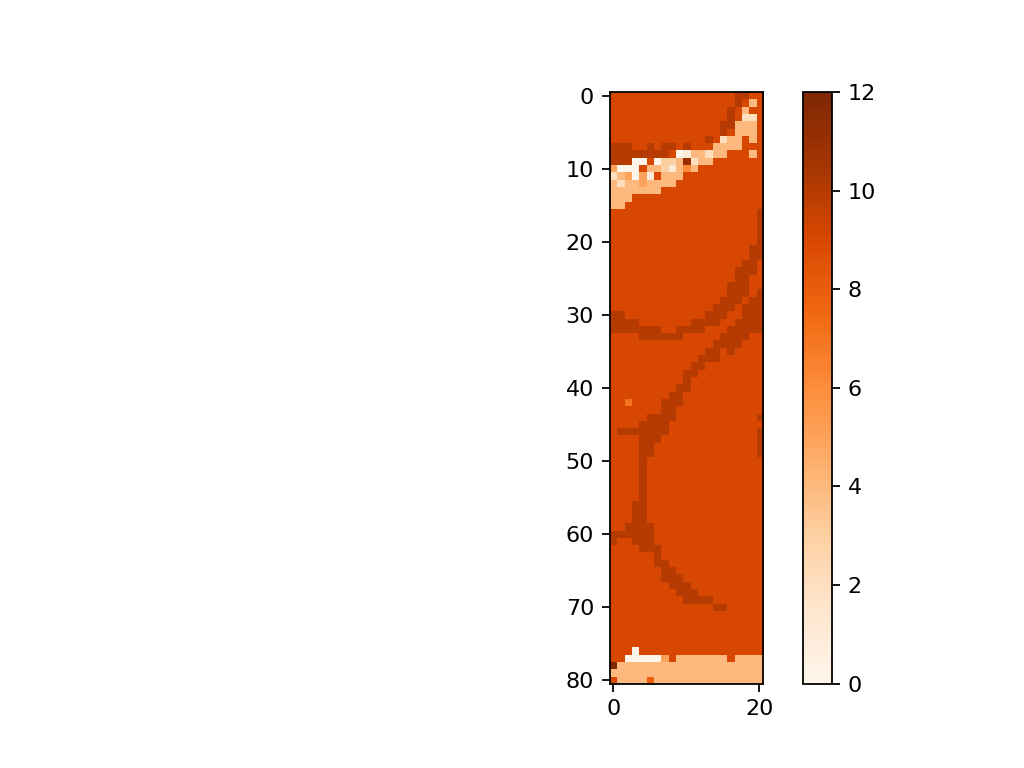

In [98]:
ac2 = AgglomerativeClustering(n_clusters=None, affinity='precomputed',
                             linkage='average', compute_full_tree=True,
                             distance_threshold=0.1)
labels2 = ac2.fit_predict(similarities)

label_picture2 = [[None for y in range(dimensions[1])] for x in range(dimensions[0])]

indexes = [(i, j) for i, sublist in enumerate(picture) for j, _ in enumerate(sublist)]

for n, (i, j) in zip(labels2, indexes):
    label_picture2[i][j] = n



fig, ax = plt.subplots()
# x = 
im = ax.imshow(label_picture2, cmap=plt.get_cmap("Oranges"))

fig.colorbar(im)

# fig.tight_layout()
plt.show()

# TODO Wybierz jeden klaster i nadaj mu kolor i następnie koloruj coraz ciemniejszymi kolorami wraz z odległością
# od tego wybranego klastra